## Load the Data: The data is loaded from the Excel file using pandas.
Code aiming to understanding the progression from MGUS to sMM to MM based on proteomic data from 16 MGUS, 12 sMM and 16 MM patients

In [1]:
import pandas as pd

# Load the Excel file
file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/Proteomic_data_testing.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
print(data.head())


  Accession_ID   Gene_Names Gene_Symbol  \
0       P00966   ASSY_HUMAN        ASS1   
1       P28907   CD38_HUMAN        CD38   
2       P60033   CD81_HUMAN        CD81   
3       P14209   CD99_HUMAN        CD99   
4       Q96CG8  CTHR1_HUMAN      CTHRC1   

                                 Protein_Description    MGUS01    MGUS02  \
0  Argininosuccinate synthase (EC 6.3.4.5) (Citru...  4.361895  4.352889   
1  ADP-ribosyl cyclase/cyclic ADP-ribose hydrolas...  6.835451  7.003038   
2  CD81 antigen (26 kDa cell surface protein TAPA...  3.126039  2.301267   
3  CD99 antigen (12E7) (E2 antigen) (Protein MIC2...  4.212218  3.407771   
4  Collagen triple helix repeat-containing protein 1  3.320215  3.769473   

     MGUS03    MGUS04    MGUS05    MGUS06  ...      MM07      MM08      MM09  \
0  4.416791  4.270819  4.271977  5.091353  ...  5.550187  3.743972  5.744277   
1  6.841021  6.329344  7.093851  6.949095  ...  6.564135  6.835407  6.228655   
2  2.200663  2.983695  2.191322  2.858062  .

## Step 2: Preprocess the Data

In [4]:
# Extract features and labels
# The first 4 columns are metadata, the rest are the proteomic data
metadata_cols = ['Accession_ID', 'Gene_Names', 'Gene_Symbol', 'Protein_Description']
feature_cols = data.columns[len(metadata_cols):]
features = data[feature_cols].values

# Create labels for the stages
# First 16 columns are MGUS, next 12 are sMM, last 16 are MM
labels = [0] * 16 + [1] * 12 + [2] * 16
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.T, labels, test_size=0.2, random_state=44)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Step 3: Train a Machine Learning Models (Starting with NN)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SophisticatedNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SophisticatedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.4)
        self.fc4 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Model parameters
input_dim = X_train.shape[1]
output_dim = 3  # Number of classes: MGUS, sMM, MM

# Initialize the model
model = SophisticatedNN(input_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy:.4f}')


Epoch [10/100], Loss: 0.7045
Epoch [20/100], Loss: 0.4744
Epoch [30/100], Loss: 0.3806
Epoch [40/100], Loss: 0.2360
Epoch [50/100], Loss: 0.1560
Epoch [60/100], Loss: 0.1406
Epoch [70/100], Loss: 0.0588
Epoch [80/100], Loss: 0.0674
Epoch [90/100], Loss: 0.0489
Epoch [100/100], Loss: 0.0365
Accuracy: 1.0000


## Visualization 
These plots will help to understand how well the model is performing and visualize the distribution of predictions relative to the actual labels.

Import Necessary Libraries

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Plot Training Loss Over Epochs

In [7]:
# First, we'll modify the training loop to store the loss values for each epoch
# Training loop with loss recording
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0514
Epoch [20/100], Loss: 0.0368
Epoch [30/100], Loss: 0.0289
Epoch [40/100], Loss: 0.0195
Epoch [50/100], Loss: 0.0132
Epoch [60/100], Loss: 0.0101
Epoch [70/100], Loss: 0.0219
Epoch [80/100], Loss: 0.0187
Epoch [90/100], Loss: 0.0107
Epoch [100/100], Loss: 0.0091


Pplot the training loss over epochs.

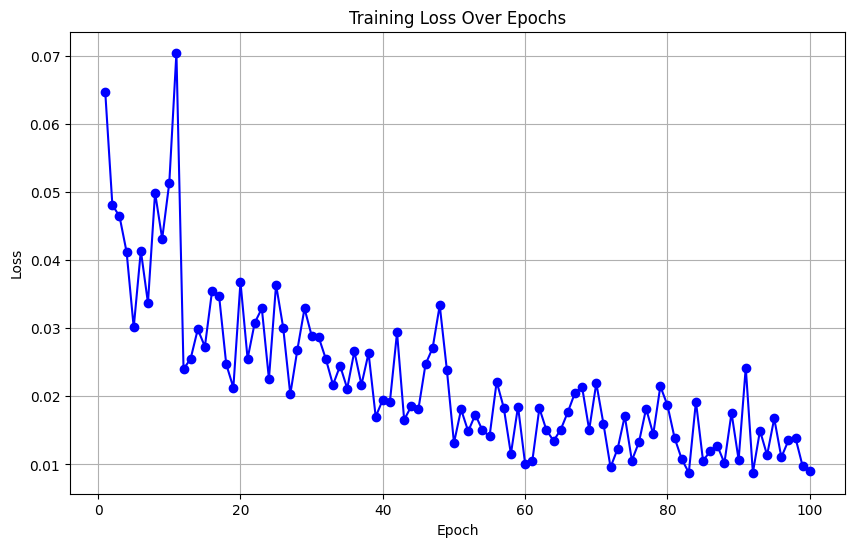

In [8]:
# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Plot Confusion Matrix

<Figure size 800x600 with 0 Axes>

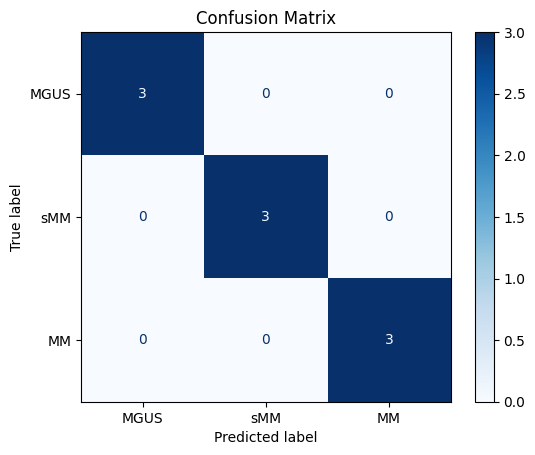

In [9]:
# Evaluation for confusion matrix
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(y_test, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MGUS', 'sMM', 'MM'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Plot Distribution of Predictions vs. Actual Labels

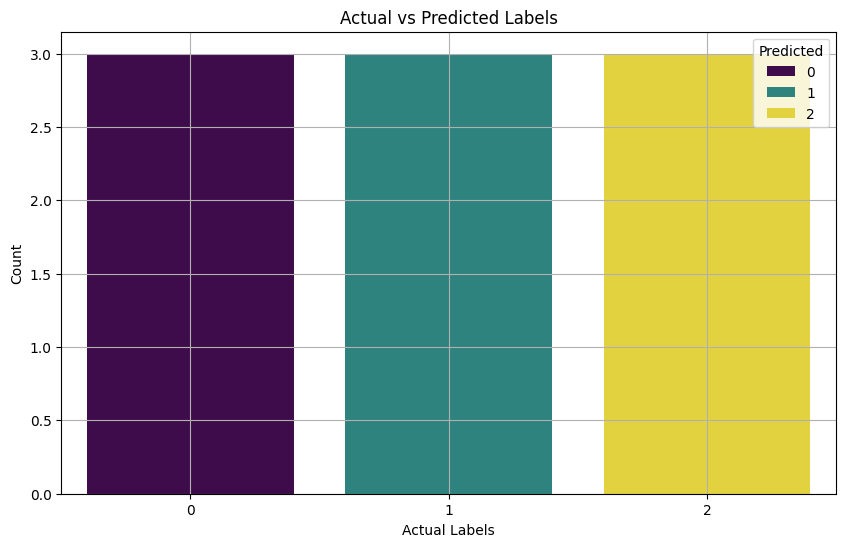

In [10]:
# Convert predictions and actual labels to numpy arrays for seaborn plotting
y_test_np = y_test.numpy()
predicted_np = predicted.numpy()

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({'Actual': y_test_np, 'Predicted': predicted_np})

# Plot the distribution of actual vs predicted labels
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df, x='Actual', hue='Predicted', palette='viridis')
plt.title('Actual vs Predicted Labels')
plt.xlabel('Actual Labels')
plt.ylabel('Count')
plt.legend(title='Predicted', loc='upper right')
plt.grid(True)
plt.show()
